## Import Packages and Libraries

In [116]:
# import packages
import pandas as pd
import numpy as np
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
import time

from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error,\
                                                        geometric_mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error as ms
from sktime.utils.plotting import plot_series


import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", rc={"figure.figsize":(12, 5)})
color_pal = sns.color_palette()
plt.style.use('ggplot')


In [117]:
# load dataset
url = 'monthly_sales_data.csv'
sales_data = pd.read_csv(url)

In [118]:
# show dataset
sales_data.head()

Category       Month  Monthly Sales  Year  DayOfWeek     Platform  \
0      Sports  2002-01-01         108592  2002          1         Xbox   
1         RPG  2002-02-01         129387  2002          4     Nintendo   
2      Sports  2002-03-01         114777  2002          4           PC   
3      Sports  2002-04-01          71738  2002          0     Nintendo   
4  Simulation  2002-05-01         142512  2002          2  PlayStation   

   Holiday  Promotion  
0        1          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0

In [119]:
# Convert Month column to datetime object
sales_data['Month'] = pd.to_datetime(sales_data['Month'])

In [120]:
sales_ts = sales_data.set_index('Month')[['Monthly Sales']]
sales_ts.tail()

Monthly Sales
Month                    
2023-08-01         132693
2023-09-01         143373
2023-10-01         126410
2023-11-01          91200
2023-12-01         159721

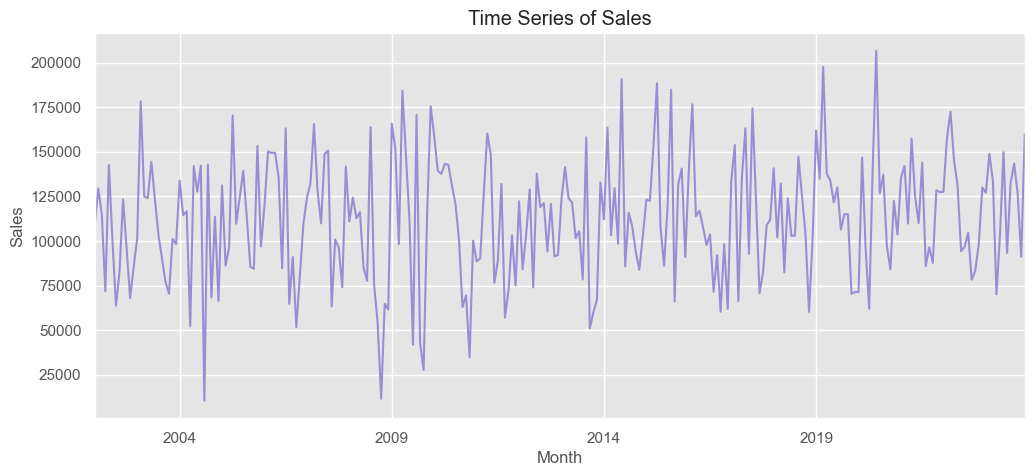

In [121]:
# plot the time series
color_pal = sns.color_palette()
sales_ts['Monthly Sales'].plot(style='-', figsize=(12,5), ms=2, title='Time Series of Sales', 
                               color= color_pal[2], ylabel='Sales');

## Decompose Time Series

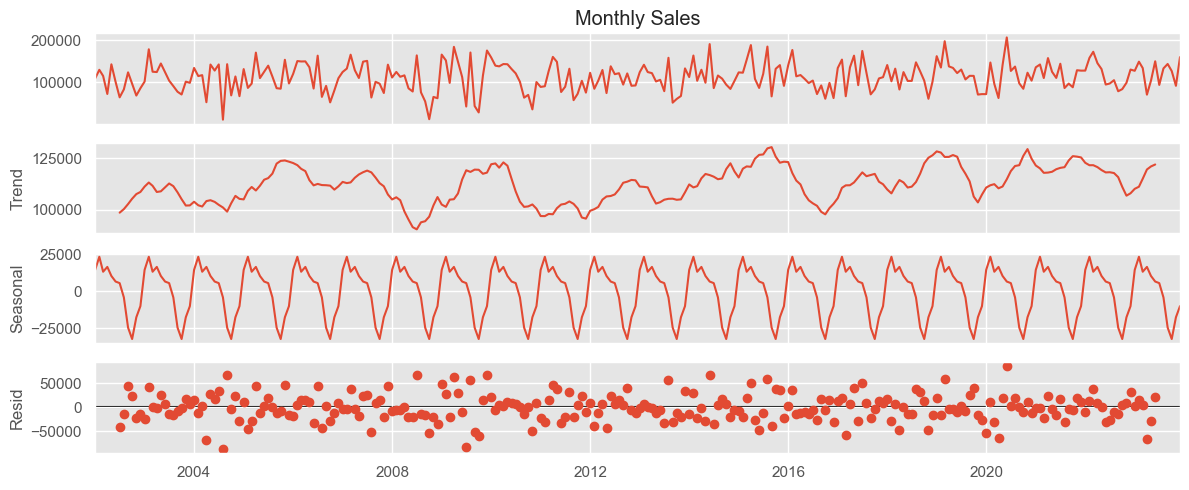

In [122]:
# decompose time series into components
sales_decompose = seasonal_decompose(sales_ts['Monthly Sales'], model='additive')

sales_decompose.plot()
plt.show()

In [123]:
# verify it's additive
sales_decompose.observed.iloc[45] == sales_decompose.trend.iloc[45] + sales_decompose.seasonal.iloc[45]\
                                            + sales_decompose.resid.iloc[45]

True

## Check for Stationary

In [124]:
# Check for stationarity by rolling windows
def check_stationary(df, col):
    df['rollmean'] = df[col].rolling(window=12).mean()
    df['rollstd'] = df[col].rolling(window=12).std()
    
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df, x=df.index, y=df[col], label='Time Series')
    sns.lineplot(data=df, x=df.index, y=df['rollmean'], label='Rolling Mean')
    sns.lineplot(data=df, x=df.index, y=df['rollstd'], label='Rolling Std');
    plt.title(label='Rolling Mean & Std')
    plt.legend()

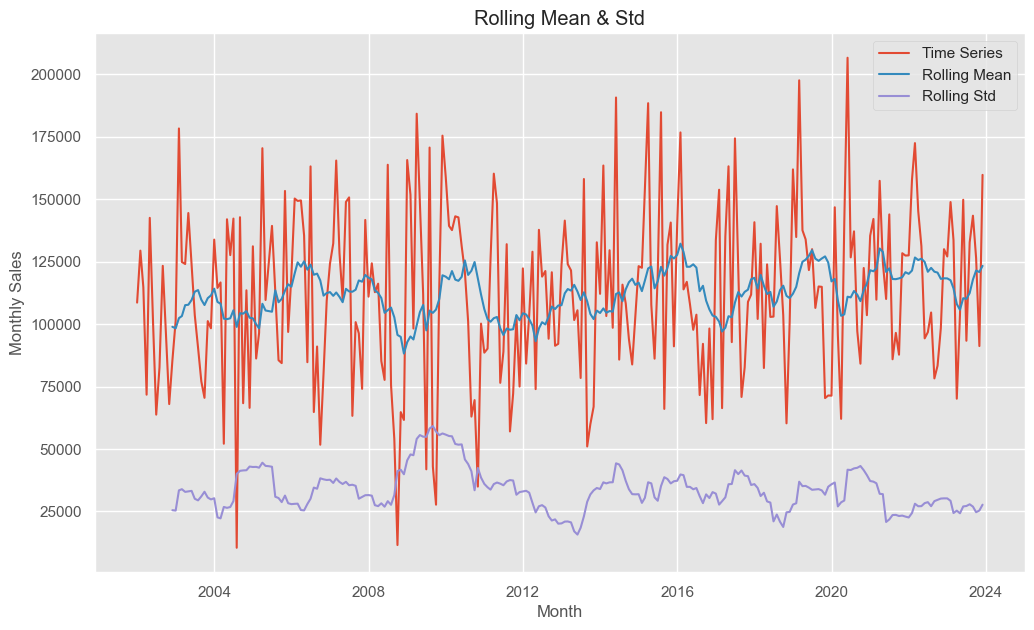

In [125]:
check_stationary(sales_ts, 'Monthly Sales')

## Tests for stationarity.
> **KPSS**:
>>*$H_{0}$*: *The data is stationary*.<br>
>>*$H_{1}$*: *The data is not stationary*.<br>
>
>
> **Adfuller**:<br>
>>*$H_{0}$*: *The data possesses a unit root is not stationary*.<br>
>>*$H_{1}$*: *The data is stationary*.


In [126]:
# import test libraries
from statsmodels.tsa.stattools import kpss, adfuller

# deactivate warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning, ConvergenceWarning
warnings.simplefilter('ignore', InterpolationWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [127]:
# function to test
def is_stationary(x):
    threshold = 0.05
    
    # for KPSS test
    stats, p, _, critical_val = kpss(x, 'ct')
    print(f'=======================KPSS=========================')
    print(f'Test Statistics = {stats}')
    print(f'p-value: {p}')
    print(f'Critical Values: {critical_val}')
    
    if p < threshold:
        kpss_log = f'For KPSS, Time Series is not stationary'
    else:
        kpss_log = f'For KPSS, Time Series is stationary'
    print(kpss_log)
        
    # for Adfuller test
    result = adfuller(x)
    print(f'\n====================Adfuller========================')
    print(f'Test Statistics = {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    
    if result[1] > threshold:
        adfull_log = f'For Adfuller, Time Series is not stationary'
    else:
        adfull_log = f'For Adfuller, Time Series is stationary'
    print(adfull_log)
          
    statement = 'Time Series is stationary'
    return (statement in kpss_log and statement in adfull_log)
        

In [128]:
is_stationary(sales_ts['Monthly Sales'])

=======================KPSS=========================
Test Statistics = 0.02700949774080778
p-value: 0.1
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
For KPSS, Time Series is stationary

====================Adfuller========================
Test Statistics = -4.471046070251255
p-value: 0.00022173509005268826
Critical Values: {'1%': -3.4565688966099373, '5%': -2.8730786194395455, '10%': -2.5729189953388762}
For Adfuller, Time Series is stationary


True

## Train/Test Split

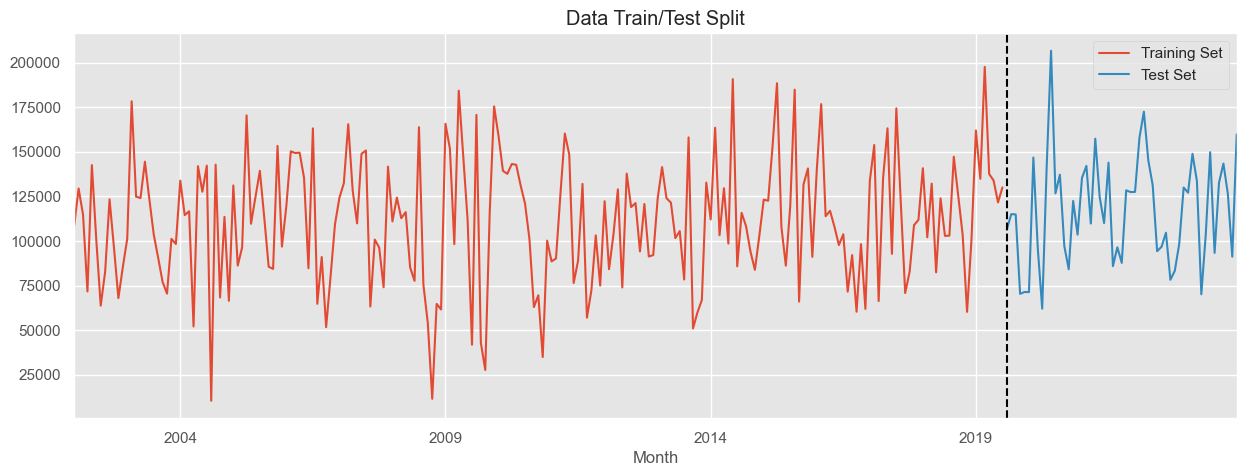

In [129]:
# split time series into train and test data
idx = round(len(sales_ts) * .8)
split_date = sales_ts.iloc[[idx]].index[0].strftime('%Y-%m-%d')
train = sales_ts[['Monthly Sales']][: idx]
test = sales_ts[['Monthly Sales']][idx:]

# visualise the train/test split
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Implementing Holt Winters (ExponentialSmoothing)

### SimpleExpSmoothing

In [130]:
# import libraries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [131]:
# Fit simple model and get forecasts
model_simple = SimpleExpSmoothing(train['Monthly Sales'])
model_fit = model_simple.fit()
prediction = model_fit.predict(start=test.index[0], end=test.index[-1])

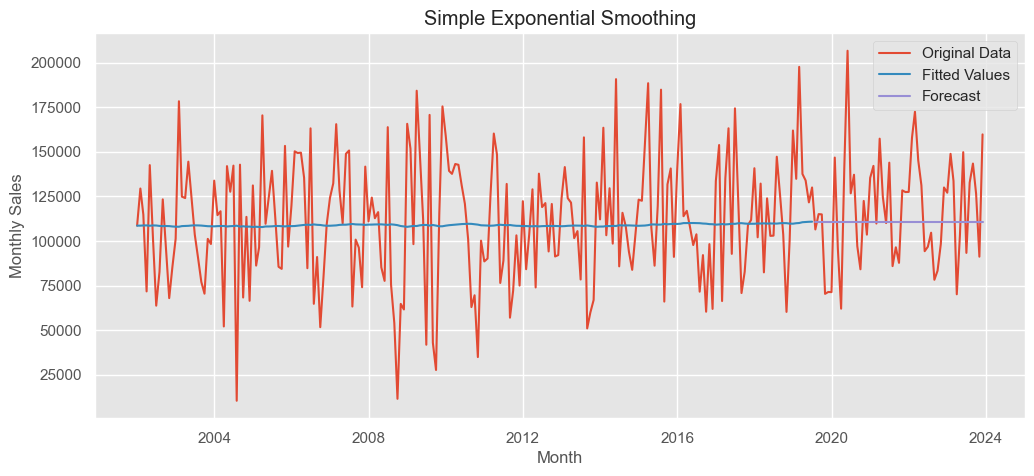

In [132]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_fit.fittedvalues, label='Fitted Values')
plt.plot(prediction, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

### Holt's Linear

In [133]:
# Fit simple model and get forecasts
model = Holt(train['Monthly Sales'], damped_trend=True)
model_holt = model.fit()
predict_holt = model_holt.predict(start=test.index[0], end=test.index[-1])

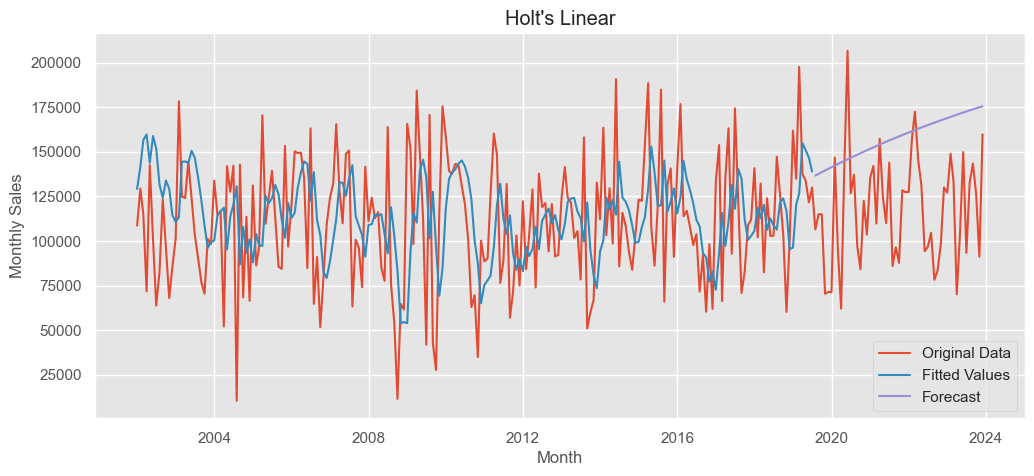

In [134]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_holt.fittedvalues, label='Fitted Values')
plt.plot(predict_holt, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title("Holt's Linear")
plt.legend()
plt.show()

### Exponential Smoothing

In [135]:
# Fit simple model and get forecasts
model = ExponentialSmoothing(train['Monthly Sales'], trend='add', seasonal='add', seasonal_periods=12)
model_holt_winters = model.fit()
predict_holt_winters = model_holt_winters.predict(start=test.index[0], end=test.index[-1])

#### Model Diagnostics

##### Some Diagnostic Functions

In [136]:
# function to visualise the residual
def plot_residual(the_model):
    residuals = the_model.resid[1:]
    fig, ax = plt.subplots(1,2)
    residuals.plot(title='Residual', ax=ax[0])
    residuals.plot(title='Density', kind='kde', ax=ax[1])
    plt.show()
    
# function to visualise the acf and pacf plots of the residual
def acf_pacf_residual_plot(the_model):
    acf_resid = plot_acf(the_model.resid)
    pacf_resid = plot_pacf(the_model.resid)

In [137]:
print(model_holt_winters.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:            Monthly Sales   No. Observations:                  211
Model:             ExponentialSmoothing   SSE                   228988330194.531
Optimized:                         True   AIC                           4421.872
Trend:                         Additive   BIC                           4475.501
Seasonal:                      Additive   AICC                          4425.434
Seasonal Periods:                    12   Date:                 Mon, 13 Jan 2025
Box-Cox:                          False   Time:                         11:08:17
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0757143                alpha                 True
smoothing_trend          

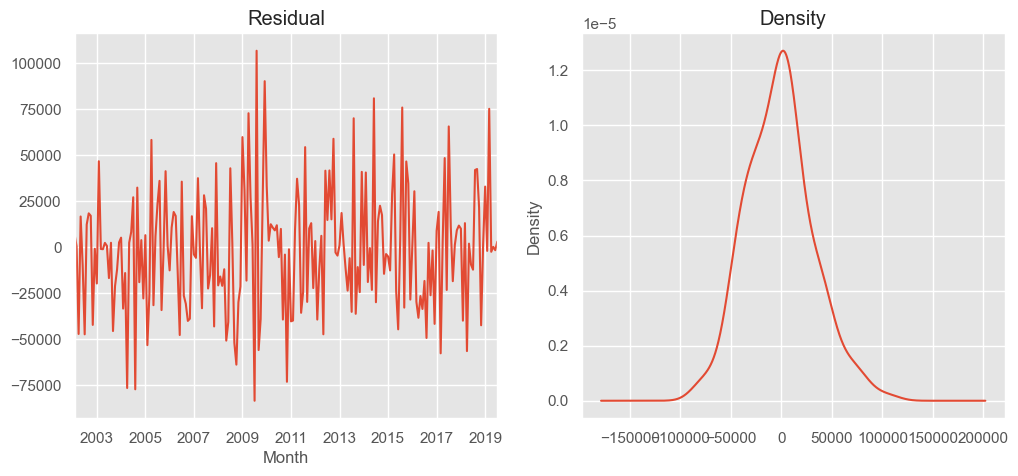

In [138]:
plot_residual(model_holt_winters)

In [139]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

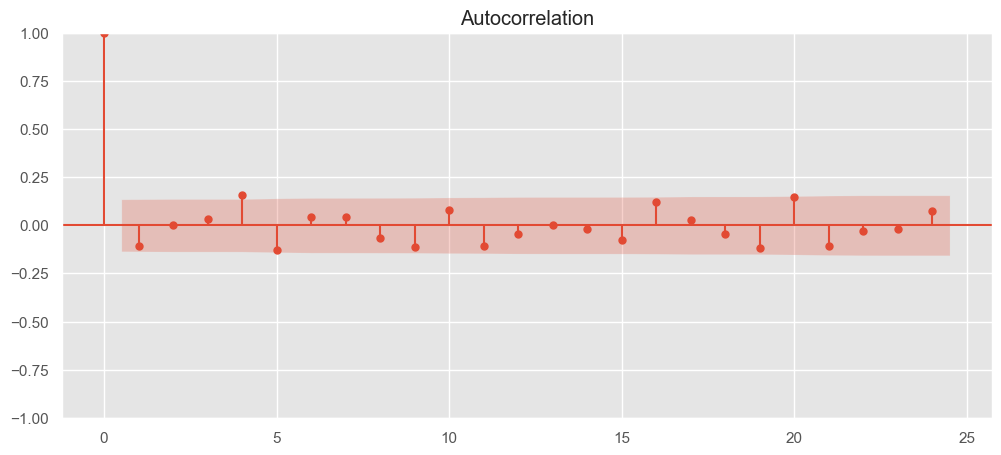

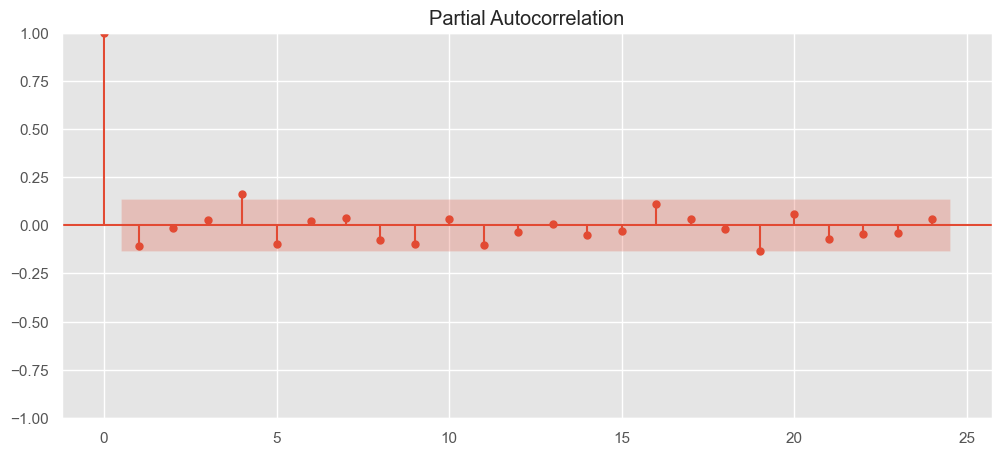

In [140]:
# plot acf and pacf for Exponential Smoothing residual
acf_pacf_residual_plot(model_holt_winters)

#### Prediction

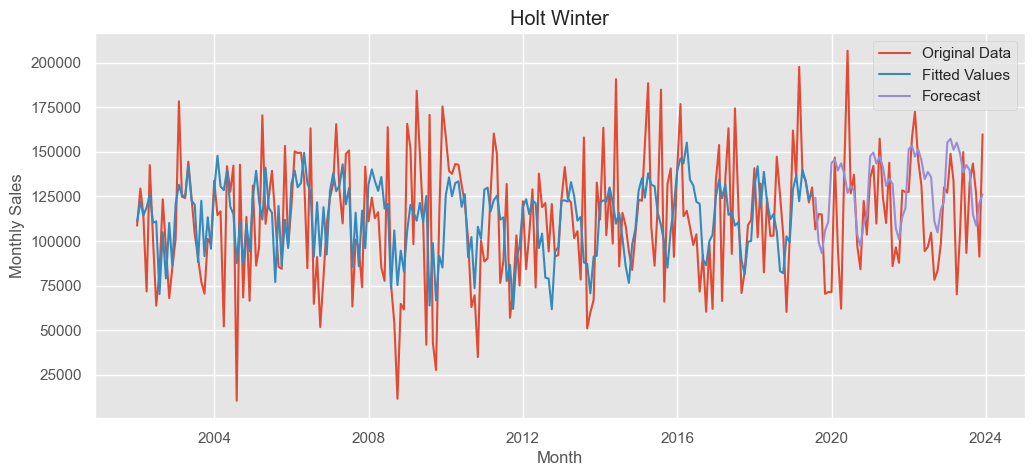

In [141]:
# plot the predicted time series with the original time series
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_holt_winters.fittedvalues, label='Fitted Values')
plt.plot(predict_holt_winters, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('Holt Winter') 
plt.legend()
plt.show()

#### Evaluation

##### Some Evaluation Functions

In [142]:
# functions for evaluation
def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def evaluate_model(actual, pred, m_name, summary=False):
    mape_eval = mape(actual, pred)
    rmse = ms(actual, pred, square_root=True)
    sk_mape = mean_absolute_percentage_error(actual, pred)
    sk_mae = mean_absolute_error(actual, pred)
    sk_gmae = geometric_mean_absolute_error(actual, pred)

    print(f'The mean absolute percentage error for {m_name} = {mape_eval}')
    print(f'The root mean square error for {m_name} = {rmse}')
    print(f'The MAPE from sktime for {m_name} = {sk_mape}')
    print(f'The mean absolute error from sktime for {m_name} = {sk_mae}')
    print(f'The geometric mean absolute error from sktime for {m_name} = {sk_gmae}')
    
    if summary:
        return [m_name, rmse, sk_mape, sk_mae, sk_gmae]

In [143]:
# create the timestamp to forecasting
futuredate = pd.DataFrame(pd.date_range(start='2024-01-01', end='2024-04-01', freq='MS'), columns=['Dates'])
futuredate.set_index('Dates', inplace=True)
futuredate

Empty DataFrame
Columns: []
Index: [2024-01-01 00:00:00, 2024-02-01 00:00:00, 2024-03-01 00:00:00, 2024-04-01 00:00:00]

In [144]:
# forecast four months ahead for Exponential Smoothing
model_holt_winters.predict(start=futuredate.index[0], end=futuredate.index[-1])

2024-01-01    159122.458715
2024-02-01    161135.279139
2024-03-01    154997.840755
2024-04-01    158967.131288
Freq: MS, dtype: float64

In [145]:
# evaluate model
evaluate_model(test, predict_holt_winters, 'model_holt_winters')

The mean absolute percentage error for model_holt_winters = 29.768812851949267
The root mean square error for model_holt_winters = 31772.046435667984
The MAPE from sktime for model_holt_winters = 0.2518280073201425
The mean absolute error from sktime for model_holt_winters = 24549.70027470819
The geometric mean absolute error from sktime for model_holt_winters = 17517.312967907677


## ARIMA Model

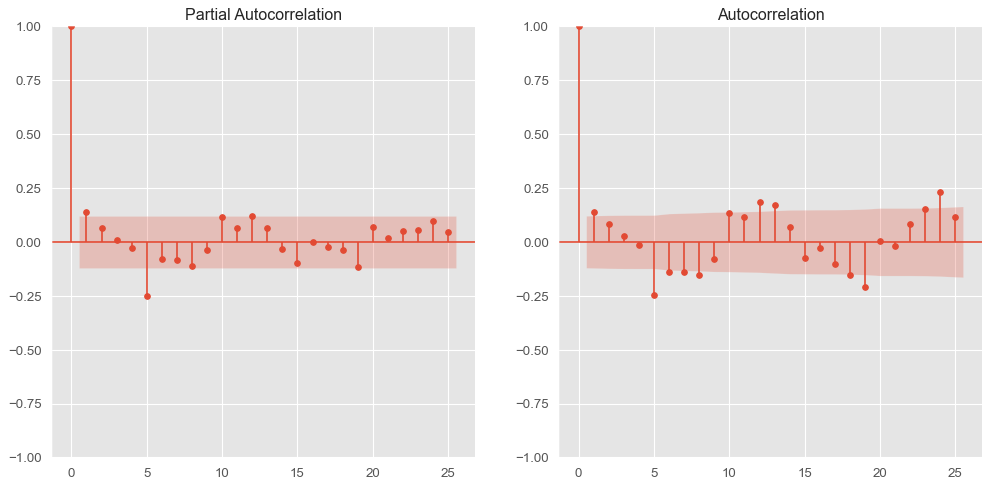

In [146]:
# plot the the correlation graphs
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7), dpi=80)
plot_pacf(sales_ts['Monthly Sales'], ax=ax1);
plot_acf(sales_ts['Monthly Sales'], ax=ax2);

# decorate
ax1.spines['top'].set_alpha(.3);ax2.spines['top'].set_alpha(.3)
ax1.spines['bottom'].set_alpha(.3);ax2.spines['bottom'].set_alpha(.3)
ax1.spines['right'].set_alpha(.3);ax2.spines['right'].set_alpha(.3)
ax1.spines['left'].set_alpha(.3);ax2.spines['left'].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

### Build Baseline ARIMA Model
- The most significant lag for the Pacf plot is 5. while the Acf is sinusoidal. Hence, the ARIMA model is ARIMA(5, 0, 5).

In [254]:
from statsmodels.tsa.arima.model import ARIMA

# fit model to data and predict 
model_arima = ARIMA(train['Monthly Sales'], order=(16, 0, 17), trend='ct').fit()
predict_arima = model_arima.predict(start=test.index[0], end=test.index[-1], freq=['MS'])

#### Model Diagnostics

In [255]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          Monthly Sales   No. Observations:                  211
Model:               ARIMA(16, 0, 17)   Log Likelihood               -2468.469
Date:                Mon, 13 Jan 2025   AIC                           5008.938
Time:                        13:16:58   BIC                           5129.605
Sample:                    01-01-2002   HQIC                          5057.714
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.055e+05   3603.613     29.269      0.000    9.84e+04    1.13e+05
x1            52.9293     37.687      1.404      0.160     -20.936     126.794
ar.L1         -0.1986     34.943     -0.006      0.9

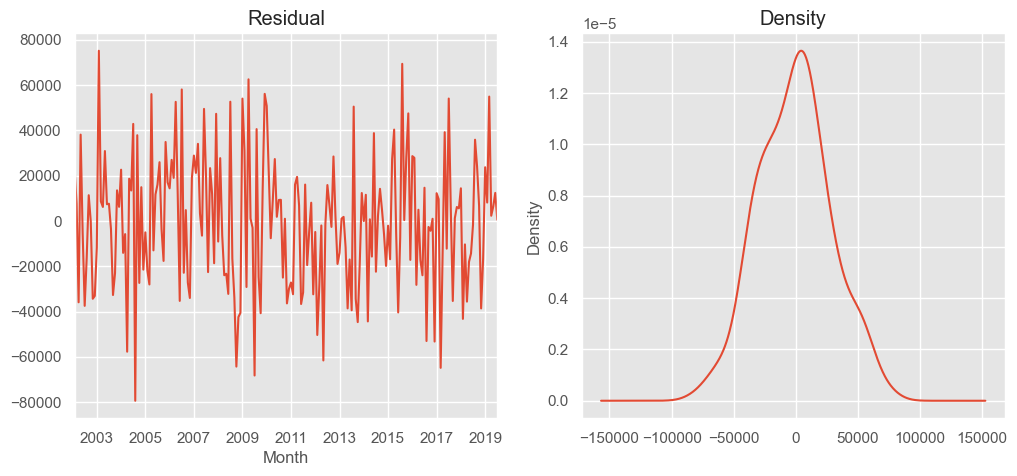

In [256]:
# plot the model's residual to check whether it's white noise
plot_residual(model_arima)

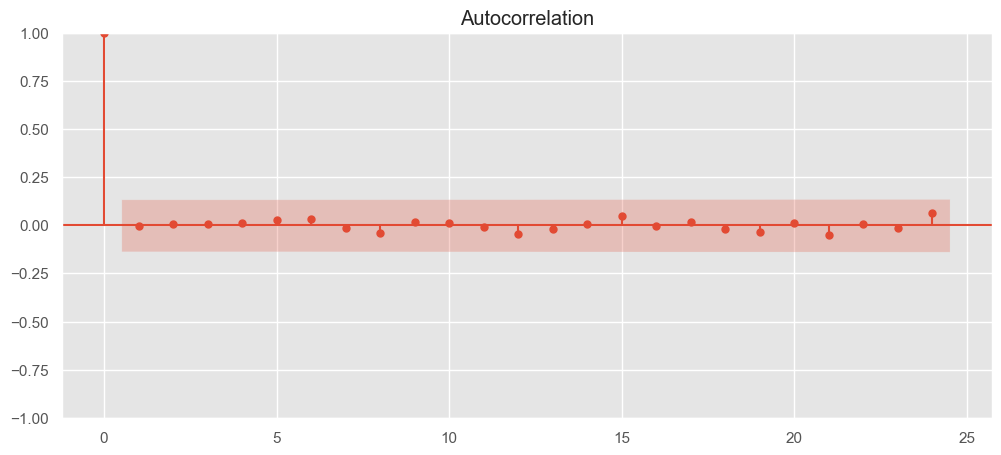

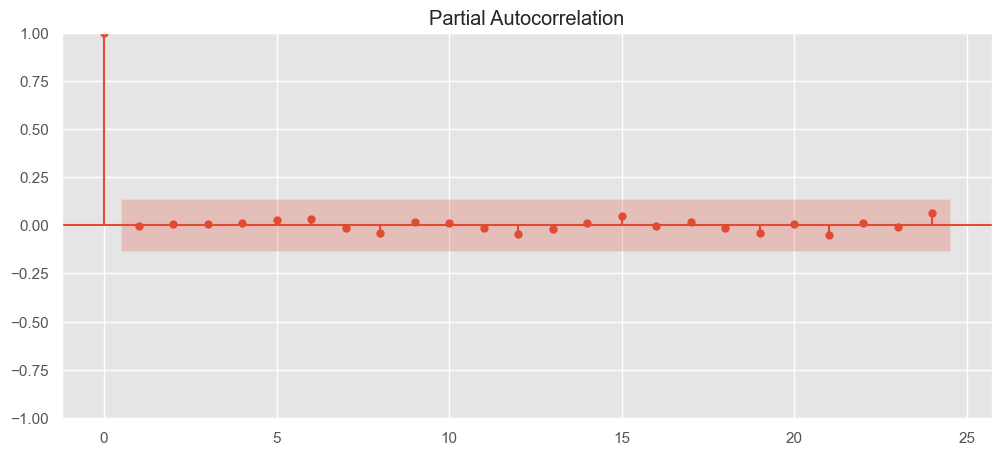

In [257]:
# plot acf and pacf for baseline ARIMA model's residual
acf_pacf_residual_plot(model_arima)

#### Prediction

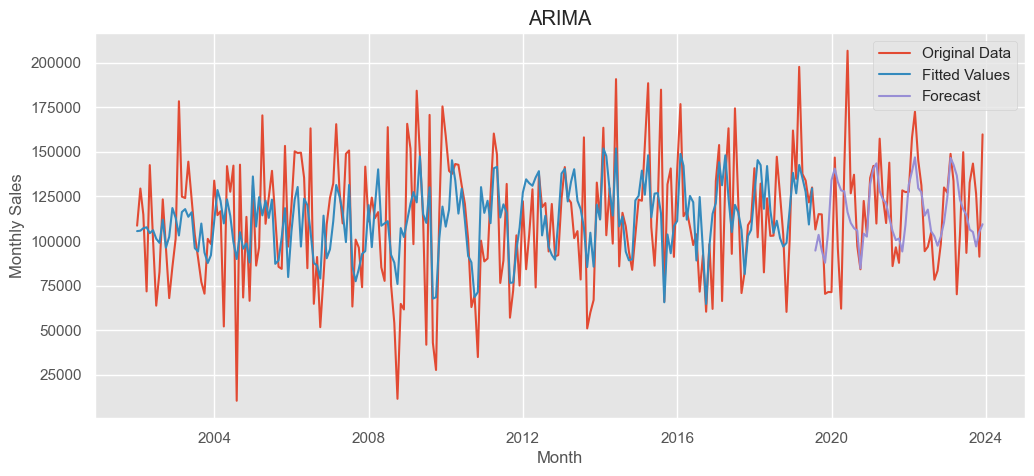

In [258]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_arima.fittedvalues, label='Fitted Values')
plt.plot(predict_arima, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('ARIMA') 
plt.legend()
plt.show()

In [259]:
# forecast four months ahead with Arima
model_arima.predict(start=futuredate.index[0], end=futuredate.index[-1])

2024-01-01    130057.940079
2024-02-01    138347.866217
2024-03-01    148606.550612
2024-04-01    138061.215368
Freq: MS, Name: predicted_mean, dtype: float64

#### Evaluation

In [260]:
# evaluate model
evaluate_model(test, predict_arima, 'model_arima')

The mean absolute percentage error for model_arima = 25.17343009272165
The root mean square error for model_arima = 28318.993227501443
The MAPE from sktime for model_arima = 0.20219387547982665
The mean absolute error from sktime for model_arima = 21346.30051881135
The geometric mean absolute error from sktime for model_arima = 13105.398866425952


### Searching for Optimal Parameters for ARIMA(p, d, q).

#### Define Parameter Space

In [154]:
# import utility library itertools
from itertools import product

# setting the parameter space for ARIMA
p = q = range(0, 30)
d = [0, 1, 2]
trend = ['n', 'c', 't', 'ct']

pdq_tr = dict(parameters = list(product(p, d, q, trend)))

print(f'Instances of parameter combinations for Seasonal ARIMA...')
print(pdq_tr['parameters'][:5])

Instances of parameter combinations for Seasonal ARIMA...
[(0, 0, 0, 'n'), (0, 0, 0, 'c'), (0, 0, 0, 't'), (0, 0, 0, 'ct'), (0, 0, 1, 'n')]


In [155]:
from sklearn.metrics import mean_squared_error
from mango import Tuner, scheduler

@scheduler.parallel(n_jobs=2)
def arima_objective_function(parameters):
    global data_values

    try:
        model = ARIMA(data_values, order=parameters[:-1], trend = parameters[-1])
        predictions = model.fit()
        mse = mean_squared_error(data_values, predictions.fittedvalues)
    except:
        mse = 1e10
    
    return mse

In [156]:
conf_Dict = dict()
conf_Dict['num_iteration'] = 150

In [157]:
data_values = list(train['Monthly Sales'])

In [158]:
tuner = Tuner(pdq_tr, arima_objective_function, conf_Dict)

In [159]:
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/100 [00:00<?, ?it/s]

best parameters: {'parameters': (27, 0, 17, 'ct')}
best loss: 781001630.3487138


In [160]:
# fit final model to data and predict 
final_arima_model = ARIMA(train['Monthly Sales'], order=(27, 0, 17), trend='ct').fit()
predict_final_arima = final_arima_model.predict(start=test.index[0], end=test.index[-1], freq=['MS'])

#### Model's Diagnostics

In [161]:
print(final_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:          Monthly Sales   No. Observations:                  211
Model:               ARIMA(27, 0, 17)   Log Likelihood               -2461.410
Date:                Mon, 13 Jan 2025   AIC                           5016.820
Time:                        12:09:49   BIC                           5174.357
Sample:                    01-01-2002   HQIC                          5080.500
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.055e+05   4377.348     24.095      0.000    9.69e+04    1.14e+05
x1            52.9134     52.316      1.011      0.312     -49.624     155.451
ar.L1          0.0676      0.403      0.168      0.8

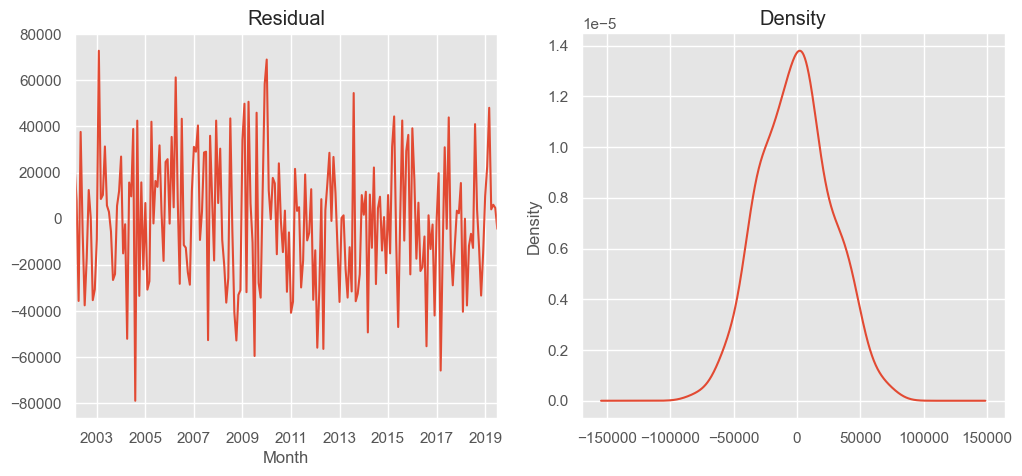

In [162]:
# plot the final_arima_model residual to check whether it's white noise
plot_residual(final_arima_model )

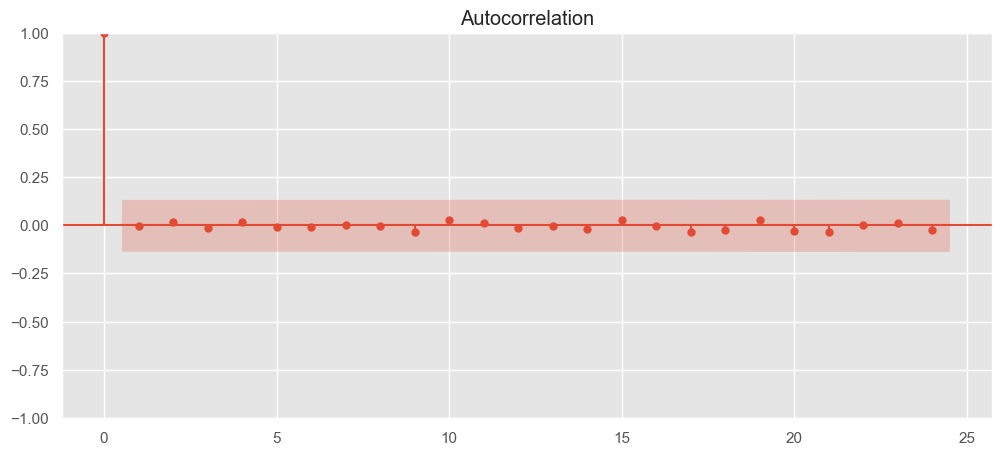

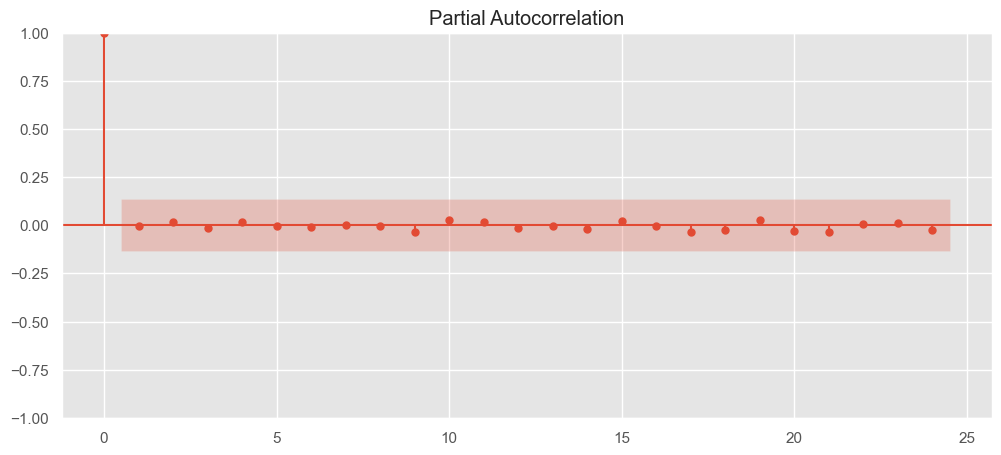

In [163]:
# plot acf and pacf for final_arima_model residual
acf_pacf_residual_plot(final_arima_model )

#### Prediction

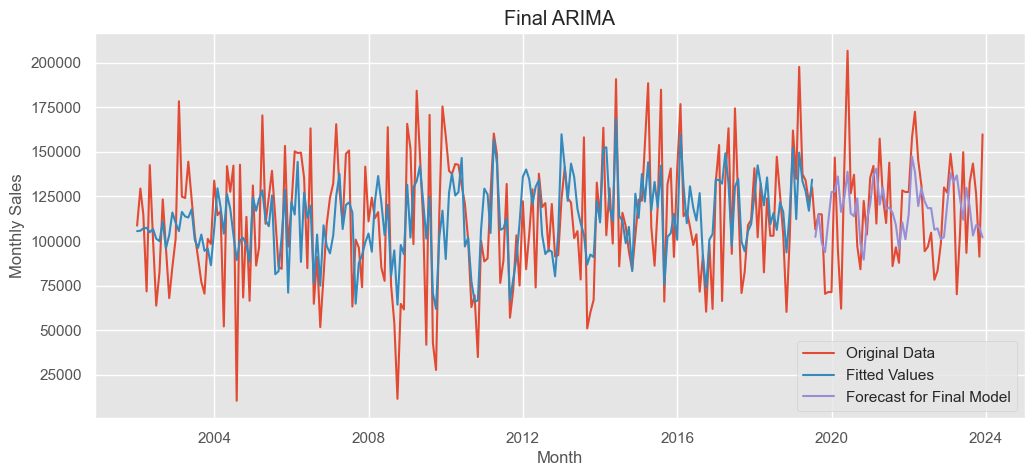

In [164]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(final_arima_model.fittedvalues, label='Fitted Values')
plt.plot(predict_final_arima, label='Forecast for Final Model')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('Final ARIMA') 
plt.legend()
plt.show()

In [165]:
# forecast four months ahead with final Arima
final_arima_model.predict(start=futuredate.index[0], end=futuredate.index[-1])

2024-01-01    120103.472132
2024-02-01    132750.072604
2024-03-01    140856.925325
2024-04-01    134102.381778
Freq: MS, Name: predicted_mean, dtype: float64

#### Evaluate Model

In [166]:
# evaluate model
evaluate_model(test, predict_final_arima, 'final_arima_model')

The mean absolute percentage error for final_arima_model = 24.744564078201666
The root mean square error for final_arima_model = 28342.165738171683
The MAPE from sktime for final_arima_model = 0.22073105828430922
The mean absolute error from sktime for final_arima_model = 23176.069352920334
The geometric mean absolute error from sktime for final_arima_model = 16079.88207728184


## SARIMA

In [167]:
# import library
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [168]:
# setting the parameter space for SARIMAX
p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]
print(f'Instances of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))

Instances of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)


In [169]:
# search for optimal combination

params_grid = dict()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train, order=param,
                           seasonal_order=param_seasonal,
                           enforce_stationarity=False,
                            enforce_invertibility=False,)
            results = model.fit()
            params_grid[results.aic] = f'ARIMA {param}x{param_seasonal}'
            keys = sorted(params_grid.keys())
        except:
            continue

In [170]:
for param in [f'{params_grid[key]} : {key}' for key in keys[:5]]:
    print(param)

ARIMA (1, 1, 1)x(0, 1, 1, 12) : 4410.700905136976
ARIMA (1, 1, 1)x(1, 1, 1, 12) : 4411.887591987436
ARIMA (0, 1, 1)x(0, 1, 1, 12) : 4412.557144391163
ARIMA (0, 1, 1)x(1, 1, 1, 12) : 4413.6360887224455
ARIMA (0, 0, 1)x(1, 1, 1, 12) : 4427.694157365205


### Fitting the Sarima Model

In [171]:
# fit model to data
model_sarima = SARIMAX(train[['Monthly Sales']], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), 
                       enforce_stationarity=False, 
                        enforce_invertibility=False)
model_results = model_sarima.fit()

In [172]:
print(model_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2115      0.142     -1.487      0.137      -0.490       0.067
ma.L1         -0.7373      0.100     -7.374      0.000      -0.933      -0.541
ma.S.L12      -0.8101      0.078    -10.351      0.000      -0.963      -0.657
sigma2      2.188e+09   3.47e-12    6.3e+20      0.000    2.19e+09    2.19e+09


### Run Model Diagnostics

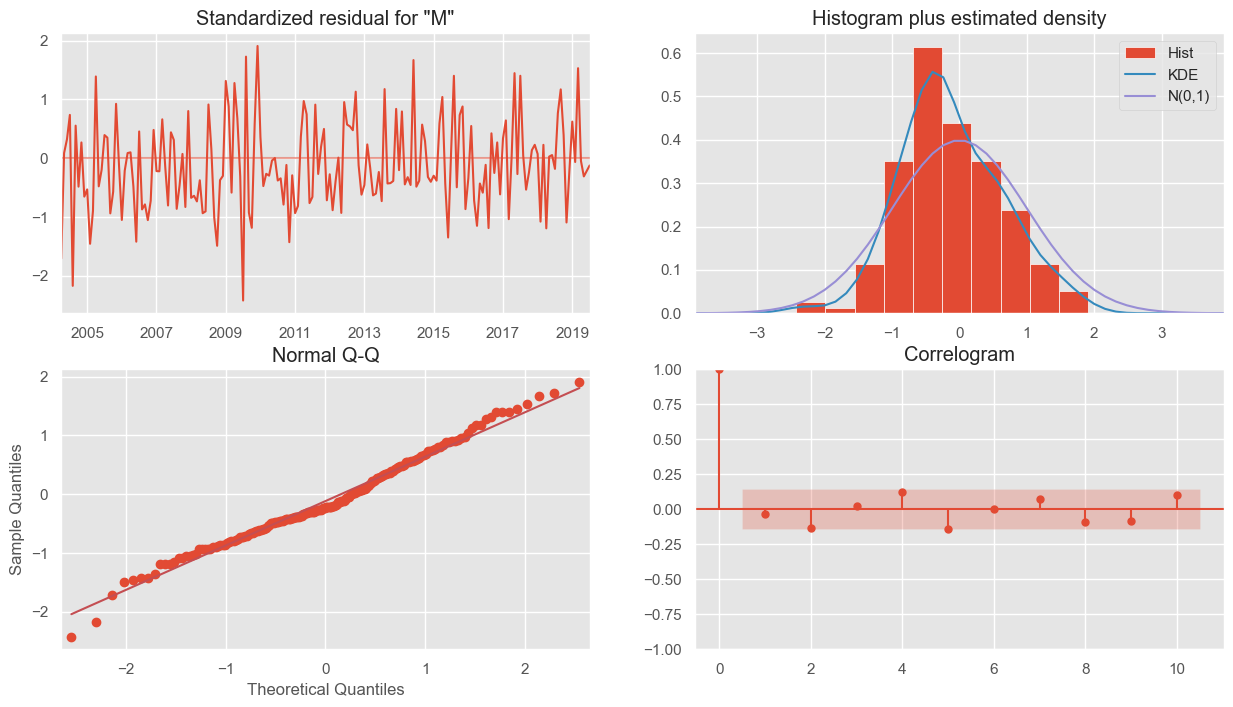

In [173]:
model_results.plot_diagnostics(figsize=(15, 8))
plt.show()

In [174]:
# fit final model to data and predict 
predict_sarima = model_results.predict(start=test.index[0], end=test.index[-1], freq=['MS'])

### Forecasting

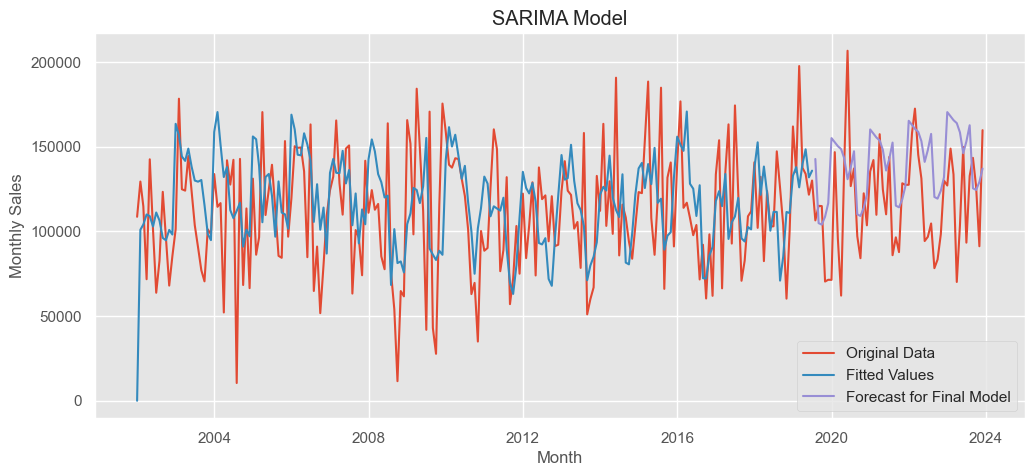

In [175]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_results.fittedvalues, label='Fitted Values')
plt.plot(predict_sarima, label='Forecast for Final Model')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('SARIMA Model') 
plt.legend()
plt.show()

In [176]:
# forecast four months ahead with final Arima
model_results.predict(start=futuredate.index[0], end=futuredate.index[-1])

2024-01-01    175497.300444
2024-02-01    173036.916491
2024-03-01    170748.503081
2024-04-01    168987.069124
Freq: MS, Name: predicted_mean, dtype: float64

### Evaluate Model

In [177]:
# evaluate model
evaluate_model(test, predict_sarima, 'model_sarima')

The mean absolute percentage error for model_sarima = 35.03648533779991
The root mean square error for model_sarima = 37573.44360422857
The MAPE from sktime for model_sarima = 0.30566757500650843
The mean absolute error from sktime for model_sarima = 29442.07732147755
The geometric mean absolute error from sktime for model_sarima = 18628.456023312978


## Prophet Model

In [178]:
#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly

import plotly.express as px

In [179]:
# get the dataset into dataframe
df_sales = sales_ts[['Monthly Sales']]
df_sales = df_sales.reset_index().rename(columns={'Monthly Sales':'y','Month': 'ds'})

In [180]:
df_sales.set_index('ds', inplace=True)
df_sales.head()

y
ds                
2002-01-01  108592
2002-02-01  129387
2002-03-01  114777
2002-04-01   71738
2002-05-01  142512

### Split Train/Test

In [181]:
# split time series into train/test data using sktime module
y_train, y_test = temporal_train_test_split(df_sales, test_size=0.2)

### Build Model

In [182]:
# instantiate a model
model_naive = Prophet(interval_width=0.95)
model_naive.fit(y_train.reset_index())

12:16:35 - cmdstanpy - INFO - Chain [1] start processing
12:16:36 - cmdstanpy - INFO - Chain [1] done processing


In [183]:
# create timestamps for test data
future = model_naive.make_future_dataframe(periods=len(y_test)+4, freq='MS')
future.tail()

ds
263 2023-12-01
264 2024-01-01
265 2024-02-01
266 2024-03-01
267 2024-04-01

In [184]:
# make prediction by the test data
forecast = model_naive.predict(future)
test_fcast = forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]
test_fcast = test_fcast.iloc[:-4]

In [185]:
test_fcast.tail()

ds    yhat_lower           yhat     yhat_upper
259 2023-08-01  55741.591014  114328.885166  169287.580962
260 2023-09-01  34071.757862   91577.060642  153367.908946
261 2023-10-01  28088.837945   83942.212415  143508.652219
262 2023-11-01  40881.217508   98867.165345  156783.403896
263 2023-12-01  49741.217498  107748.553652  166325.068590

In [186]:
forecast[['yhat']].iloc[-4:]

yhat
264  134798.355235
265  138423.233260
266  131101.573778
267  137279.434532

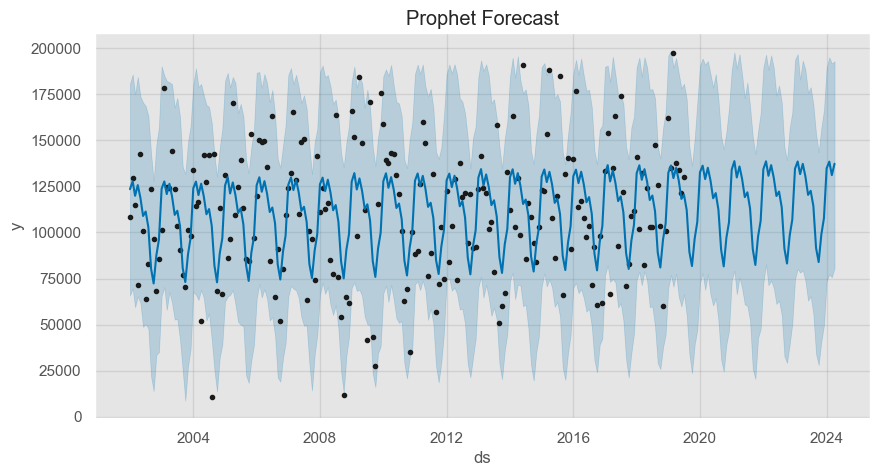

In [187]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_naive.plot(forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

In [188]:
# concatenate the predicted data and the actual data
y_yhat = pd.concat([df_sales, test_fcast[['ds', 'yhat']].set_index('ds').loc[y_test.index[0]:]], axis=1)

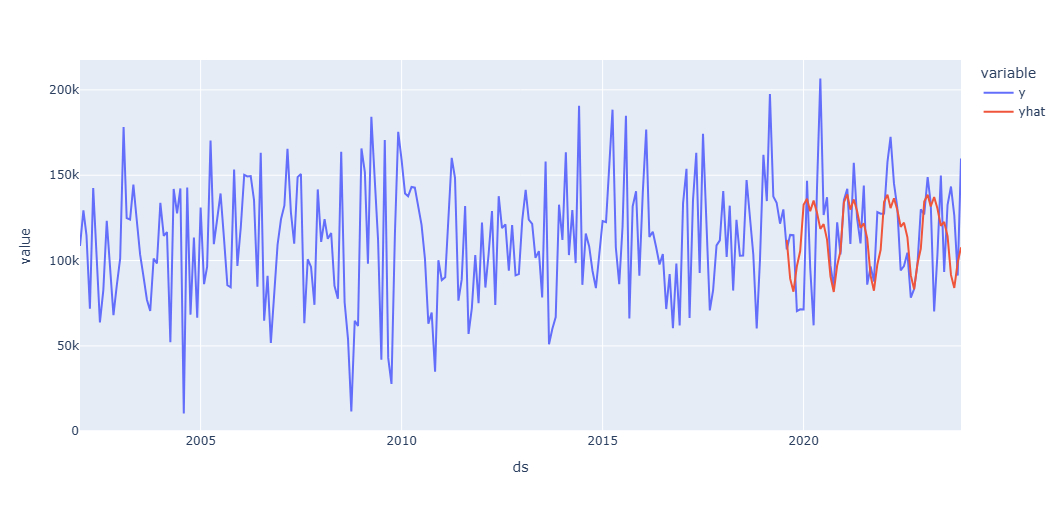

In [189]:
# visualise the actual sales with the predicted sales
fig = px.line(y_yhat, x=y_yhat.index, y=['y', 'yhat'], width=900, height=512)
fig.show()

#### Model Diagnostics

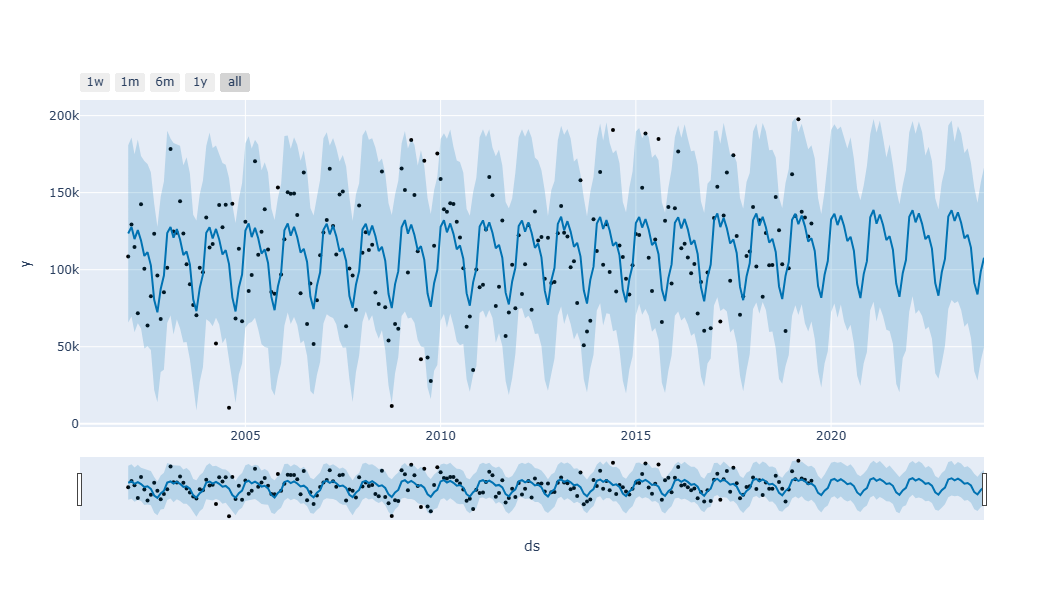

In [190]:
plot_plotly(model_naive, test_fcast)

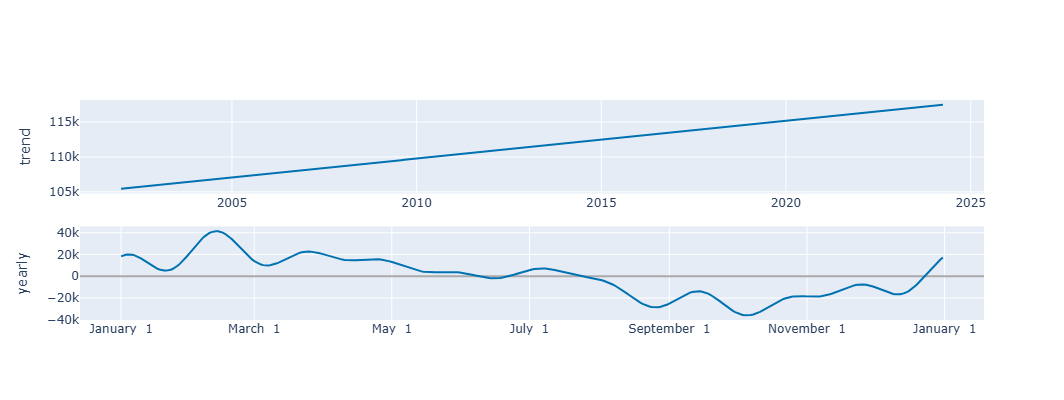

In [191]:
# plot the components of the time series
fig = plot_components_plotly(model_naive, forecast)
fig.show()

#### Compare Forecast to Actual

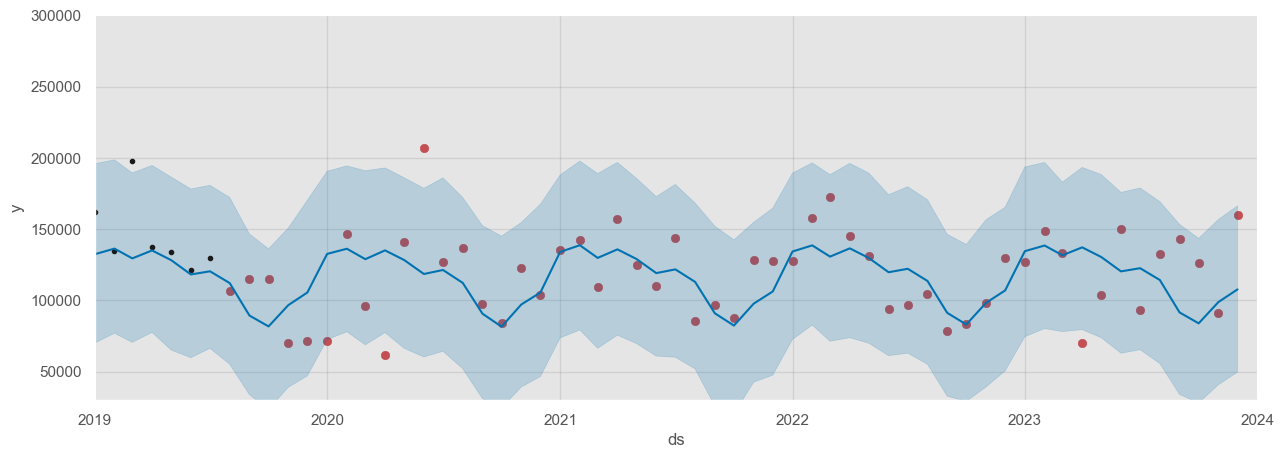

In [192]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(y_test.index, y_test['y'], color='r')
fig = model_naive.plot(test_fcast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2019'), upper=pd.to_datetime('01-01-2024'))
ax.set_ylim(30_000, 300_000);

#### Evaluate Naive Model

In [193]:
# Evaluate the naive model
filter = test_fcast['ds'] >= y_test.index[0]
predict_df = test_fcast[filter][['ds', 'yhat']]
predict_df = predict_df.merge(df_sales.reset_index(), on='ds')

In [194]:
evaluate_model(predict_df['y'], predict_df['yhat'], 'model_naive')

The mean absolute percentage error for model_naive = 20.677949775716424
The root mean square error for model_naive = 29407.407812888385
The MAPE from sktime for model_naive = 0.20677949775716425
The mean absolute error from sktime for model_naive = 21885.445455378747
The geometric mean absolute error from sktime for model_naive = 12268.014813654807


### Forecasting

In [195]:
# instantiate a model
model_naive_2 = Prophet(interval_width=0.95)
model_naive_2.fit(df_sales.reset_index())

12:17:46 - cmdstanpy - INFO - Chain [1] start processing
12:17:46 - cmdstanpy - INFO - Chain [1] done processing


In [196]:
# create timestamps for test data
future = model_naive_2.make_future_dataframe(periods=4, freq='MS')
future.tail()

ds
263 2023-12-01
264 2024-01-01
265 2024-02-01
266 2024-03-01
267 2024-04-01

In [197]:
# make prediction by the test data
forecast_2 = model_naive_2.predict(future)
test_fcast_2 = forecast_2[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]

In [198]:
test_fcast_2[['yhat']].tail(4)

yhat
264  120748.903804
265  132596.848758
266  114721.489546
267  128168.189954

### Using Cross Validation

- To check those timestamps that are anomalies

In [199]:
model_cv = Prophet()
model_cv.fit(y_train.reset_index())
df_cv = cross_validation(model_cv, initial='365 days', period='60 days', horizon ='60 days')

12:18:01 - cmdstanpy - INFO - Chain [1] start processing
12:18:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/100 [00:00<?, ?it/s]

12:18:01 - cmdstanpy - INFO - Chain [1] start processing
12:18:24 - cmdstanpy - INFO - Chain [1] done processing
12:18:24 - cmdstanpy - INFO - Chain [1] start processing
12:18:50 - cmdstanpy - INFO - Chain [1] done processing
12:18:50 - cmdstanpy - INFO - Chain [1] start processing
12:19:21 - cmdstanpy - INFO - Chain [1] done processing
12:19:21 - cmdstanpy - INFO - Chain [1] start processing
12:19:28 - cmdstanpy - INFO - Chain [1] done processing
12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:58 - cmdstanpy - INFO - Chain [1] done processing
12:19:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:32 - cmdstanpy - INFO - Chain [1] done processing
12:20:32 - cmdstanpy - INFO - Chain [1] start processing
12:20:33 - cmdstanpy - INFO - Chain [1] done processing
12:20:33 - cmdstanpy - INFO - Chain [1] start processing
12:20:33 - cmdstanpy - INFO - Chain [1] done processing
12:20:34 - cmdstanpy - INFO - Chain [1] start processing
12:20:34 - cmdstanpy - INFO - Chain [1]

In [200]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0   7 days  2.413567e+09  49128.072295  39069.236091  0.372425  0.254228   
1   8 days  7.289813e+09  85380.399496  56637.827775  0.670913  0.273526   
2   9 days  7.163115e+09  84635.187570  56030.595072  0.683943  0.273526   
3  10 days  7.407427e+09  86066.410855  58490.733187  0.734177  0.297507   
4  11 days  7.080765e+09  84147.279742  55182.253856  0.681736  0.309320   
5  12 days  6.614109e+09  81327.170512  50862.487035  0.638297  0.297507   
6  13 days  6.615301e+09  81334.498292  50894.826764  0.835564  0.297507   
7  14 days  1.905792e+09  43655.379622  35062.075780  0.560643  0.218511   
8  15 days  1.917098e+09  43784.673599  35326.752325  0.574450  0.245644   
9  16 days  1.964060e+09  44317.711959  34979.105029  0.603445  0.245644   
10 17 days  2.257118e+09  47509.131008  36895.458711  0.645774  0.245966   
11 18 days  2.569522e+09  50690.455909  41124.361289  0.607559  0.373651   
12 19 days  2.356635e+09  48545.188761  37370.518662  0.470929  0.294469   
13 20 days  2.075825e+09  45561.221803  34261.542113  0.435965  0.294469   
14 21 days  1.689995e+09  41109.547315  30514.254428  0.361807  0.279541   
15 22 days  1.001977e+09  31654.019520  23697.787455  0.261025  0.120299   
16 23 days  8.284782e+08  28783.297929  22518.848826  0.259696  0.120299   
17 24 days  8.083904e+08  28432.207260  22539.838126  0.278527  0.120299   
18 25 days  8.396817e+08  28977.262301  23399.250074  0.280440  0.131464   
19 26 days  8.485096e+08  29129.187606  22969.860527  0.266413  0.131464   
20 27 days  8.250792e+08  28724.192514  22078.918782  0.253002  0.131464   
21 28 days  7.939290e+08  28176.744892  21098.047668  0.245077  0.117346   
22 29 days  6.228829e+08  24957.622892  18133.571250  0.196192  0.101554   
23 30 days  5.210636e+08  22826.817321  15854.176074  0.160606  0.076264   
24 31 days  5.556914e+08  23573.107677  16608.236795  0.186082  0.076264   
25 32 days  5.173194e+08  22744.655583  16330.278384  0.195190  0.149923   
26 33 days  6.338435e+08  25176.248816  18634.441321  0.230495  0.195152   
27 34 days  6.387024e+08  25272.562782  20021.246088  0.241123  0.233295   
28 35 days  7.777390e+08  27887.973039  22621.437798  0.485732  0.226933   
29 36 days  7.605580e+08  27578.216129  23252.184965  0.491310  0.233295   
30 37 days  1.017494e+09  31898.174961  27174.505782  0.513605  0.243649   
31 38 days  1.209490e+09  34777.727962  27798.643475  0.507076  0.233295   
32 39 days  1.578021e+09  39724.313675  30098.459218  0.500399  0.243649   
33 40 days  2.457630e+09  49574.486457  37679.652952  0.607002  0.243649   
34 41 days  2.976396e+09  54556.351902  41819.339835  0.392759  0.281528   
35 42 days  3.548896e+09  59572.612175  46788.861091  0.420674  0.351239   
36 43 days  3.245099e+09  56965.772152  42748.955530  0.387171  0.281528   
37 44 days  3.160950e+09  56222.327449  42911.903120  0.376499  0.281528   
38 45 days  2.843082e+09  53320.560740  39827.834184  0.351351  0.281528   
39 46 days  2.003828e+09  44764.131977  31862.541790  0.254242  0.143106   
40 47 days  1.350103e+09  36743.741272  25736.549278  0.209540  0.143106   
41 48 days  1.264040e+09  35553.336859  26934.510966  0.266041  0.176948   
42 49 days  1.470615e+09  38348.603954  30606.348163  0.298852  0.247920   
43 50 days  1.363505e+09  36925.670598  31082.295842  0.283996  0.217243   
44 51 days  1.236784e+09  35167.935601  29939.386110  0.279317  0.217243   
45 52 days  1.299926e+09  36054.482031  30992.641877  0.288924  0.247920   
46 53 days  1.150916e+09  33925.148901  28265.382808  0.258473  0.232937   
47 54 days  8.837785e+08  29728.412331  24219.019632  0.206117  0.191646   
48 55 days  7.812302e+08  27950.494773  23475.218982  0.209838  0.191646   
49 56 days  8.116110e+08  28488.786976  23553.607616  0.215775  0.201300   
50 57 days  8.503208e+08  29160.260524  24303.997475  0.214485  0.221339   
51 58 days  1.089971e+09  33014.705544  27279.22641

In [201]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(10)

ds           yhat    yhat_lower     yhat_upper       y     cutoff  \
21  2004-11-01   16551.046044   -170.038884   33635.253505  113510 2004-09-17   
17  2004-07-01   37692.463588  21931.109388   52082.112719  142221 2004-05-20   
11  2004-01-01   41801.141647  40959.869802   42561.140020  133804 2003-11-22   
30  2005-08-01   43828.925800  17426.372912   69450.837465  113140 2005-07-14   
26  2005-04-01   70798.639681  49349.791651   92713.944709  170386 2005-03-16   
78  2009-08-01   72055.235060  39844.790448  107164.101425  170648 2009-06-23   
82  2009-12-01   88181.569185  48268.981561  126032.238294  175416 2009-10-21   
116 2012-10-01   63683.106881  24814.527886  103481.864660  120734 2012-08-06   
150 2015-08-01  101029.217617  61314.536219  137589.475886  184786 2015-07-22   
152 2015-10-01   74230.715088  33586.904090  111211.480483  131721 2015-09-20   

          mape  overestimate  
21   85.418865         False  
17   73.497259         False  
11   68.759423         False  
30   61.261335         False  
26   58.448089         False  
78   57.775517         False  
82   49.730031         False  
116  47.253378         False  
150  45.326368         False  
152  43.645497         False

### Hyperparameters Tuning

In [202]:
# set values for some hyperparameters
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [203]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
# holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
print(seasonality_prior_scale_range)

[0.01, 2.5075, 5.005, 7.5024999999999995, 10.0]


In [237]:
start_time = time.time()

# parameter space
param_grid = {"changepoint_prior_scale": changepoint_prior_scale_range,
              "seasonality_prior_scale": seasonality_prior_scale_range }
        
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    model_hcv = Prophet(**params, interval_width=.95).fit(df_sales.reset_index())  # Fit model with given params
    df_hcv = cross_validation(model_hcv, initial='690 days', period='120 days', horizon = '300 days', parallel='processes')
    df_hp = performance_metrics(df_hcv, rolling_window=1)
    print(df_hp)
    rmses.append(df_hp["rmse"].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["rmse"] = rmses

print(tuning_results.head())
params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])

print("--- %s seconds ---" % (time.time() - start_time)) #about 5 minutes

12:52:38 - cmdstanpy - INFO - Chain [1] start processing
12:52:38 - cmdstanpy - INFO - Chain [1] done processing
12:52:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:52:38 - cmdstanpy - INFO - Chain [1] start processing
12:52:41 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.172512e+09  34241.964533  27436.861083  0.362413  0.193357   

      smape  coverage  
0  0.259461  0.936535  


12:53:10 - cmdstanpy - INFO - Chain [1] start processing
12:53:10 - cmdstanpy - INFO - Chain [1] done processing
12:53:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:53:11 - cmdstanpy - INFO - Chain [1] start processing
12:53:12 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.312847e+09  36233.226597  27718.019019  0.336006  0.184102   

      smape  coverage  
0  0.264827  0.838765  


12:53:45 - cmdstanpy - INFO - Chain [1] start processing
12:53:45 - cmdstanpy - INFO - Chain [1] done processing
12:53:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:53:45 - cmdstanpy - INFO - Chain [1] start processing
12:53:45 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.333141e+09  36512.205209  27877.817001  0.335576  0.189914   

      smape  coverage  
0  0.266464  0.835334  


12:54:22 - cmdstanpy - INFO - Chain [1] start processing
12:54:22 - cmdstanpy - INFO - Chain [1] done processing
12:54:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:54:22 - cmdstanpy - INFO - Chain [1] start processing
12:54:23 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.351484e+09  36762.536307  27953.363742  0.335625  0.187434   

      smape  coverage  
0  0.267281  0.830189  


12:55:03 - cmdstanpy - INFO - Chain [1] start processing
12:55:03 - cmdstanpy - INFO - Chain [1] done processing
12:55:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:55:03 - cmdstanpy - INFO - Chain [1] start processing
12:55:04 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse         rmse           mae      mape     mdape  \
0 300 days  1.365700e+09  36955.37318  28034.106291  0.336321  0.189537   

      smape  coverage  
0  0.268481   0.83705  


12:55:47 - cmdstanpy - INFO - Chain [1] start processing
12:55:47 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.170657e+09  34214.863102  27531.397611  0.362279  0.192433   

      smape  coverage  
0  0.259984  0.936535  


12:56:13 - cmdstanpy - INFO - Chain [1] start processing
12:56:13 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.296829e+09  36011.517619  27436.578295  0.325081  0.189201   

      smape  coverage  
0  0.264845   0.83705  


12:56:38 - cmdstanpy - INFO - Chain [1] start processing
12:56:38 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.320734e+09  36341.897722  27533.083459  0.325898  0.189164   

      smape  coverage  
0  0.265561  0.843911  


12:57:07 - cmdstanpy - INFO - Chain [1] start processing
12:57:07 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse          mae      mape     mdape  \
0 300 days  1.327405e+09  36433.569024  27586.13344  0.325488  0.186298   

      smape  coverage  
0  0.266776  0.833619  


12:57:34 - cmdstanpy - INFO - Chain [1] start processing
12:57:34 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.326423e+09  36420.088611  27586.279236  0.325561  0.188027   

      smape  coverage  
0  0.266532   0.83705  


12:58:01 - cmdstanpy - INFO - Chain [1] start processing
12:58:01 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.190322e+09  34501.040132  27733.929606  0.362607  0.194782   

      smape  coverage  
0  0.261916   0.93482  


12:58:27 - cmdstanpy - INFO - Chain [1] start processing
12:58:27 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.329342e+09  36460.147181  27868.490012  0.324782  0.193036   

      smape  coverage  
0  0.268955  0.845626  


12:58:55 - cmdstanpy - INFO - Chain [1] start processing
12:58:55 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae     mape    mdape  \
0 300 days  1.614501e+09  40180.850476  29078.388277  0.35106  0.19158   

      smape  coverage  
0  0.271912  0.843911  


12:59:55 - cmdstanpy - INFO - Chain [1] start processing
12:59:55 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.358646e+09  36859.816712  28042.818983  0.327977  0.193877   

      smape  coverage  
0  0.270068  0.843911  


13:00:21 - cmdstanpy - INFO - Chain [1] start processing
13:00:21 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape    mdape  \
0 300 days  1.363194e+09  36921.455691  28081.699863  0.327312  0.19597   

      smape  coverage  
0  0.270469   0.83705  


13:00:48 - cmdstanpy - INFO - Chain [1] start processing
13:00:49 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.214970e+09  34856.422436  27979.335433  0.363348  0.201148   

      smape  coverage  
0  0.264033  0.929674  


13:01:15 - cmdstanpy - INFO - Chain [1] start processing
13:01:16 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.486527e+09  38555.508358  28775.421555  0.339205  0.197051   

     smape  coverage  
0  0.27193  0.833619  


13:02:12 - cmdstanpy - INFO - Chain [1] start processing
13:02:12 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.534958e+09  39178.541491  28997.603818  0.344736  0.198251   

      smape  coverage  
0  0.273096  0.842196  


13:03:11 - cmdstanpy - INFO - Chain [1] start processing
13:03:11 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape     mdape  \
0 300 days  1.665482e+09  40810.318695  29468.449072  0.354125  0.197124   

      smape  coverage  
0  0.274617  0.835334  


13:04:08 - cmdstanpy - INFO - Chain [1] start processing
13:04:08 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse         rmse           mae      mape     mdape  \
0 300 days  1.487742e+09  38571.25947  28815.879301  0.336971  0.194777   

      smape  coverage  
0  0.272923  0.843911  


13:05:07 - cmdstanpy - INFO - Chain [1] start processing
13:05:07 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse          mae      mape    mdape  \
0 300 days  1.233388e+09  35119.621908  28171.64773  0.362865  0.20904   

      smape  coverage  
0  0.265718  0.924528  


13:05:34 - cmdstanpy - INFO - Chain [1] start processing
13:05:34 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse         rmse           mae      mape    mdape  \
0 300 days  1.606737e+09  40084.12386  29457.578742  0.346557  0.20022   

      smape  coverage  
0  0.276757  0.835334  


13:06:35 - cmdstanpy - INFO - Chain [1] start processing
13:06:35 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae    mape    mdape  \
0 300 days  1.753461e+09  41874.347997  29926.005054  0.3595  0.19907   

      smape  coverage  
0  0.278708  0.831904  


13:07:36 - cmdstanpy - INFO - Chain [1] start processing
13:07:36 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse         rmse           mae      mape     mdape  \
0 300 days  1.679693e+09  40984.05287  29748.099112  0.353987  0.198641   

      smape  coverage  
0  0.278229  0.830189  


13:08:41 - cmdstanpy - INFO - Chain [1] start processing
13:08:41 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse          rmse           mae      mape    mdape  \
0 300 days  1.682249e+09  41015.228384  29777.976218  0.354248  0.19889   

      smape  coverage  
0  0.278838  0.828473  
   changepoint_prior_scale  seasonality_prior_scale          rmse
0                    0.001                   0.0100  34241.964533
1                    0.001                   2.5075  36233.226597
2                    0.001                   5.0050  36512.205209
3                    0.001                   7.5025  36762.536307
4                    0.001                  10.0000  36955.373180
--- 1029.2527031898499 seconds ---


In [238]:
params_dict

{'changepoint_prior_scale': 0.12575,
 'seasonality_prior_scale': 0.01,
 'rmse': 34214.863102232586}

#### Promotion and Holiday Data

In [239]:
hol_dates = sales_data[sales_data['Holiday'] == 1]['Month']

In [240]:
# Create a DataFrame of holidays with date and holiday name
holidays = pd.DataFrame({'holiday': 'popular_holidays',
                        'ds': pd.to_datetime(hol_dates), # ADD YOUR CUSTOM HOLIDAYS
                        'lower_window': -3,
                        'upper_window': 1})

holidays.reset_index(drop=True, inplace=True)

In [241]:
# get the promo data into a series
promo_data = sales_data['Promotion']

In [242]:
# create the promo dataframe
promo_regressor_df = pd.DataFrame({'ds': sales_data['Month'], 'is_promo': promo_data})
promo_regressor_df.tail()

ds  is_promo
259 2023-08-01         0
260 2023-09-01         0
261 2023-10-01         1
262 2023-11-01         0
263 2023-12-01         0

### Backtesting with Tuned Metrics

In [243]:
# instantiate a model
model_bt = Prophet(changepoint_prior_scale=params_dict['changepoint_prior_scale'], 
                   seasonality_prior_scale=params_dict['seasonality_prior_scale'], interval_width=.95, holidays=holidays)

# add the promotion feature to the model
model_bt.add_regressor('is_promo')

# add the promotion feature to the training data
y_train_new = y_train.reset_index()
y_train_new['is_promo'] = promo_regressor_df['is_promo'][promo_regressor_df['ds'] < y_test.index[0]]

# Fit model with given params
model_bt.fit(y_train_new) 

# add the promotion feature to the test data
future['is_promo'] = promo_regressor_df['is_promo']
future['is_promo'].fillna(value=0, inplace=True)
    
forecast_bt = model_bt.predict(future)
test_fcast_bt = forecast_bt[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]

13:10:44 - cmdstanpy - INFO - Chain [1] start processing
13:10:44 - cmdstanpy - INFO - Chain [1] done processing


In [244]:
# Evaluate the backtesting model
filter = test_fcast_bt['ds'] >= y_test.index[0] 
predict_bt_df = test_fcast_bt[filter][['ds', 'yhat']]
predict_bt_df = predict_bt_df.merge(df_sales.reset_index(), on='ds')

#### Evaluation

In [245]:
# evaluate model_bt
evaluate_model(predict_bt_df['y'], predict_bt_df['yhat'], 'model_bt')

The mean absolute percentage error for model_bt = 21.926246240912356
The root mean square error for model_bt = 28376.489542041036
The MAPE from sktime for model_bt = 0.21926246240912356
The mean absolute error from sktime for model_bt = 23049.43065273074
The geometric mean absolute error from sktime for model_bt = 17107.01779611705


#### Forecasting

In [246]:
test_fcast_bt[['yhat']].tail(4)

yhat
264  124841.233683
265  125996.820070
266  121373.207842
267  124162.989524

#### Model Diagnostics

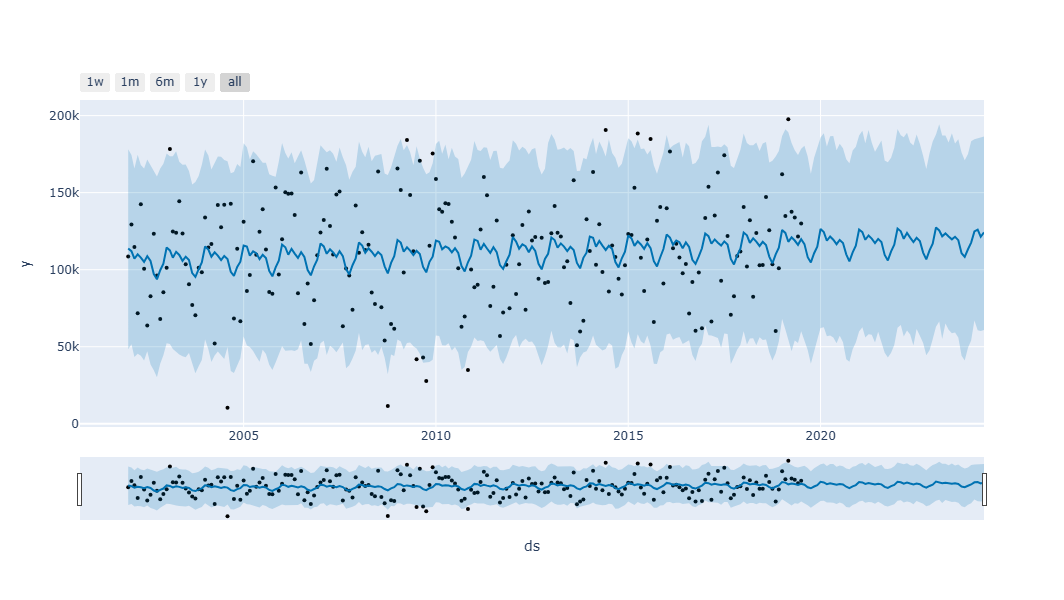

In [247]:
# visualise the model's predctions
plot_plotly(model_bt, test_fcast_bt)

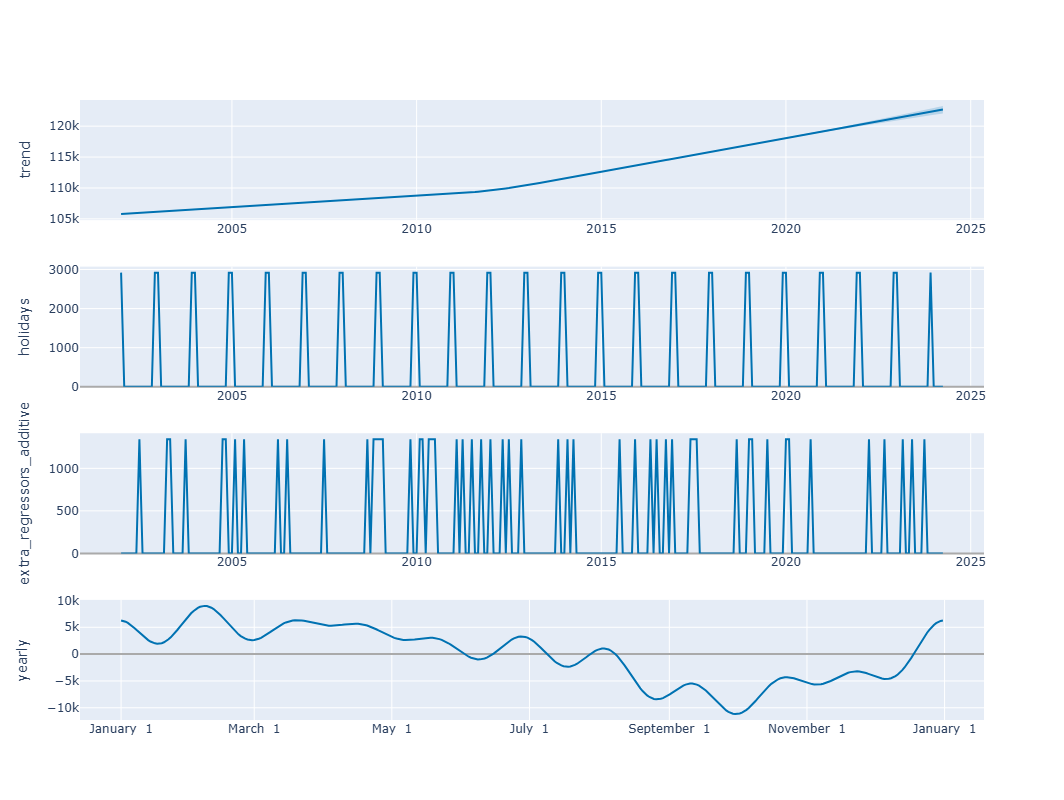

In [215]:
# plot the components of the time series
fig = plot_components_plotly(model_bt, forecast_bt)
fig.show()

#### Compare Forecast to Actual

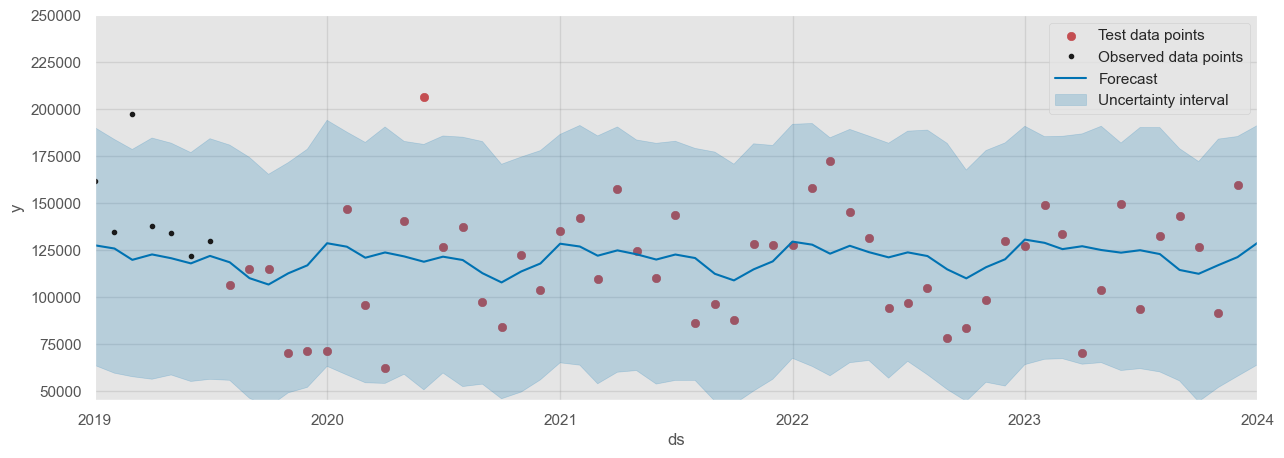

In [216]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(y_test.index, y_test['y'], color='r', label='Test data points')
fig = model_bt.plot(test_fcast_bt, ax=ax)
ax.legend()
ax.set_xbound(lower=pd.to_datetime('01-01-2019'), upper=pd.to_datetime('01-01-2024'))
ax.set_ylim(45_000, 250_000);

### Final Forecasting

In [217]:
# instantiate a model
model_ph = Prophet(changepoint_prior_scale=params_dict['changepoint_prior_scale'], 
                   seasonality_prior_scale=params_dict['seasonality_prior_scale'], interval_width=.95, holidays=holidays)

# add the promotion feature to the whole series
df_sales_copy = df_sales.copy()
df_sales_copy.reset_index(inplace=True)
df_sales_copy['is_promo'] = sales_data['Promotion']

# add the promotion feature to the model
model_ph.add_regressor('is_promo')


# Fit model with given params
model_ph.fit(df_sales_copy)

12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:41 - cmdstanpy - INFO - Chain [1] done processing


In [218]:
# define timestamps for the forecast
future_ph = model_ph.make_future_dataframe(periods=4, freq='MS')

# add the promotion feature to the series
future_ph['is_promo'] = sales_data['Promotion']
future_ph['is_promo'][future_ph['is_promo'].isna()] = 0

In [219]:
# make forecast for the next 4 months
forecast_ph = model_ph.predict(future_ph)
final_forecast = forecast_ph[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].tail(4)

In [220]:
final_forecast[['yhat']]

yhat
264  126639.262006
265  130482.954241
266  124024.075383
267  124949.229110

## Model Evaluation
- ### Final evaluation of models

In [261]:
# import additional metrics libraries
from sktime.performance_metrics.forecasting import mean_squared_scaled_error, mean_absolute_scaled_error

def metrics(actual, pred, name, train, to_return=True):
    print(f'==================={name}=========================')
    metric = evaluate_model(actual, pred, name, to_return)
    # scaled metrics
    rmsse = mean_squared_scaled_error(actual, pred, y_train=train, square_root=True)
    mase = mean_absolute_scaled_error(actual, pred, y_train=train)
    print(f'The Root Mean Squared Scaled Error for {name} = {rmsse}')
    print(f'The Mean Absolute Scaled Error for {name} = {mase}', end='\n\n')
    
    metric.extend([rmsse, mase])
    return (metric[0], metric[1:])

In [262]:
model_list = [(test, predict_holt_winters, 'model_holt_winters', train),
             (test, predict_arima, 'model_arima', train),
             (test, predict_final_arima, 'final_arima_model', train),
             (test, predict_sarima, 'model_sarima', train),
             (predict_df['y'], predict_df['yhat'], 'model_naive', y_train),
             (predict_bt_df['y'], predict_bt_df['yhat'], 'model_bt', y_train)]

metric_name = ['rmse', 'mape', 'mae', 'gmae', 'rmsse', 'mase']

In [263]:
def metric_evaluate(mod_params, metric_nm):
    df_list = []
    for mod in mod_params:
        df_list.append(metrics(*mod))
    df_dict = dict(df_list)
    metric_df = pd.DataFrame(df_dict, index=metric_nm)
    return metric_df.T

In [264]:
eval_df = metric_evaluate(model_list, metric_name)

===================model_holt_winters=========================
The mean absolute percentage error for model_holt_winters = 29.768812851949267
The root mean square error for model_holt_winters = 31772.046435667984
The MAPE from sktime for model_holt_winters = 0.2518280073201425
The mean absolute error from sktime for model_holt_winters = 24549.70027470819
The geometric mean absolute error from sktime for model_holt_winters = 17517.312967907677
The Root Mean Squared Scaled Error for model_holt_winters = 0.6821422674755758
The Mean Absolute Scaled Error for model_holt_winters = 0.6747914518420663

===================model_arima=========================
The mean absolute percentage error for model_arima = 25.17343009272165
The root mean square error for model_arima = 28318.993227501443
The MAPE from sktime for model_arima = 0.20219387547982665
The mean absolute error from sktime for model_arima = 21346.30051881135
The geometric mean absolute error from sktime for model_arima = 13105.398866

In [265]:
eval_df_copy = eval_df.sort_values('mase').copy()

In [266]:
eval_df_copy.reset_index().rename(columns={'index': 'Models'})

Models          rmse      mape           mae          gmae  \
0         model_arima  28318.993228  0.202194  21346.300519  13105.398866   
1         model_naive  29407.407813  0.206779  21885.445455  12268.014814   
2            model_bt  28376.489542  0.219262  23049.430653  17107.017796   
3   final_arima_model  28342.165738  0.220731  23176.069353  16079.882077   
4  model_holt_winters  31772.046436  0.251828  24549.700275  17517.312968   
5        model_sarima  37573.443604  0.305668  29442.077321  18628.456023   

      rmsse      mase  
0  0.608006  0.586740  
1  0.631374  0.601560  
2  0.609240  0.633554  
3  0.608503  0.637035  
4  0.682142  0.674791  
5  0.806698  0.809267